In [1]:
import os, sys 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

import copy
from nflows import transforms, distributions, flows

import torch
from torch import nn
from torch import optim
import torch.distributions as D

import matplotlib as mpl
import matplotlib.pyplot as plt

/home/fede/.conda/envs/gmm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# bgs = aTable.Table.read('BGS_ANY_full.provabgs.lite.hdf5')
# is_bgs_bright = bgs['is_bgs_bright']
# is_bgs_faint = bgs['is_bgs_faint']

# bgs = bgs[bgs['is_bgs_bright']]

# # Gathering data
# # Exluding galaxies for z < 0.01 and z > 0.4 because I don't have the mass completeness limit for those
# mask_zlim = (bgs['Z_HP'].data > 0.01) & (bgs['Z_HP'].data < 0.4)

# z_tot = bgs['Z_HP'].data[mask_zlim]
# x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
# x_median_tot = np.median(x_tot, axis=1)
# w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
# w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
# vmax_tot = bgs['Vmax'].data[mask_zlim]


# mass_comp_lim = mass_completeness_limit(z_tot)
# mask_mlim = []
# for i in range(len(x_median_tot)):
#     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    

# mask = (w_zfail_tot > 0) & (mask_mlim)

# z = z_tot[mask].astype(np.float32)
# x = x_tot[mask].astype(np.float32)
# x_median = x_median_tot[mask].astype(np.float32)
# w_zfail = w_zfail_tot[mask].astype(np.float32)
# w_fib = w_fib_tot[mask].astype(np.float32)
# vmax = vmax_tot[mask].astype(np.float32)


# f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
# v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
# v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
# v_sub = v_zmax - v_zmin


# # w_spec * 1/Vmax
# w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
# n = np.sum(w)/v_sub

# # Spectroscopic weights
# w_spec = (w_zfail*w_fib)

In [3]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)

In [4]:
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=0)
else:
    device = 'cpu'

/tmp/ipykernel_16591/462559051.py:41: RuntimeWarning: divide by zero encountered in true_divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


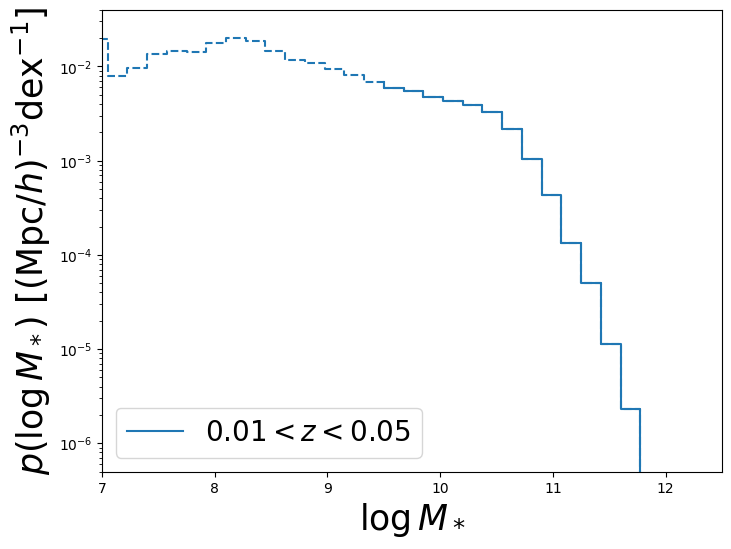

In [10]:
bgs = aTable.Table.read('BGS_ANY_full.provabgs.lite.hdf5')
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]

dat_dir = '/home/fede'

# fig = plt.figure(figsize=(8,6))
# sub = fig.add_subplot(111)

f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
zmins, zmaxs = [0.01], [0.05]

mlim = [8.975,
  9.325,
  9.5,
  9.85,
  10.024999999999999,
  10.2,
  10.375,
  10.55,
  10.725,
  10.725,
  10.899999999999999,
  10.899999999999999,
  11.075,
  11.075,
  11.425,
  11.425]

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.last.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization    
    #_ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
    #             weights=w_import[zlim]*norm, #10000./np.sum(w_import[zlim]), 
    #             range=(6., 13.), bins=40, histtype='step', 
    #             color='k', linestyle='--', linewidth=1) 
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
    #sub.axvline(mlim[2*i+1], color='C%i' % i, linestyle=':')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-7, 4e-2)
plt.show()